In [1]:
import json
import cv2
import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image
from utils.bbox2rect import bbox2rect,plot_bbox_label,plot_anchor_box

import torch


# 1. 整理数据集

In [2]:
dirpath = 'data/cowboyoutfits/'

In [3]:
#加载数据集中train的label
train_json_url = dirpath + 'train.json'
with open(train_json_url,'r') as f:
    train_json = json.load(f)

In [4]:
labelmap = {i['id']:i['name'] for i in train_json['categories']}
colormap = {87:[255,0,0],1034:[25,125,25],131:[0,0,255],318:[255,255,0],588:[255,0,255]}
idsmap = {train_json['categories'][i]['id']:i for i in range(len(train_json['categories']))}
clsmap = {i:train_json['categories'][i]['id'] for i in range(len(train_json['categories']))}
labelmap,colormap,idsmap,clsmap

({87: 'belt',
  1034: 'sunglasses',
  131: 'boot',
  318: 'cowboy_hat',
  588: 'jacket'},
 {87: [255, 0, 0],
  1034: [25, 125, 25],
  131: [0, 0, 255],
  318: [255, 255, 0],
  588: [255, 0, 255]},
 {87: 0, 1034: 1, 131: 2, 318: 3, 588: 4},
 {0: 87, 1: 1034, 2: 131, 3: 318, 4: 588})

## 1.1) 样例展示

In [5]:
train_sample = train_json['images'][150]
train_sample

{'id': 6995932726905766043,
 'file_name': '61168bbfc3bf809b.jpg',
 'neg_category_ids': [228, 333, 334, 391, 434],
 'pos_category_ids': [69, 216, 308, 433, 514],
 'width': 1024,
 'height': 576,
 'source': 'OpenImages'}

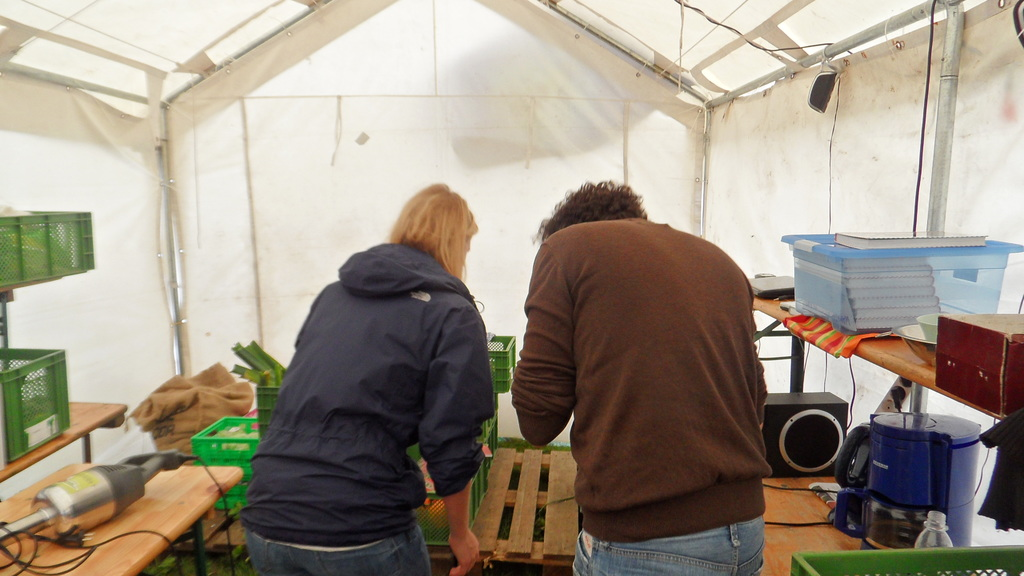

In [6]:
img = cv2.imread(dirpath + 'images/'+train_sample['file_name'])
Image.fromarray(img[:,:,::-1])

## 1.2) 画bounding box

In [7]:
train_json['annotations'][0]

{'id': 12550146,
 'image_id': 15526467552013451612,
 'freebase_id': '/m/017ftj',
 'category_id': 1034,
 'iscrowd': False,
 'bbox': [102.49, 181.12, 137.08, 97.92],
 'area': 13423.09}

In [8]:
train_sample_anchor = [anchor for anchor in train_json['annotations'] if anchor['image_id'] == train_sample['id']]

In [9]:
train_sample_anchor

[{'id': 5773277,
  'image_id': 6995932726905766043,
  'freebase_id': '/m/032b3c',
  'category_id': 588,
  'iscrowd': False,
  'bbox': [510.72, 145.92, 267.52, 393.6],
  'area': 105295.97},
 {'id': 5773279,
  'image_id': 6995932726905766043,
  'freebase_id': '/m/032b3c',
  'category_id': 588,
  'iscrowd': False,
  'bbox': [234.88, 240.0, 257.92, 316.16],
  'area': 81544.0}]

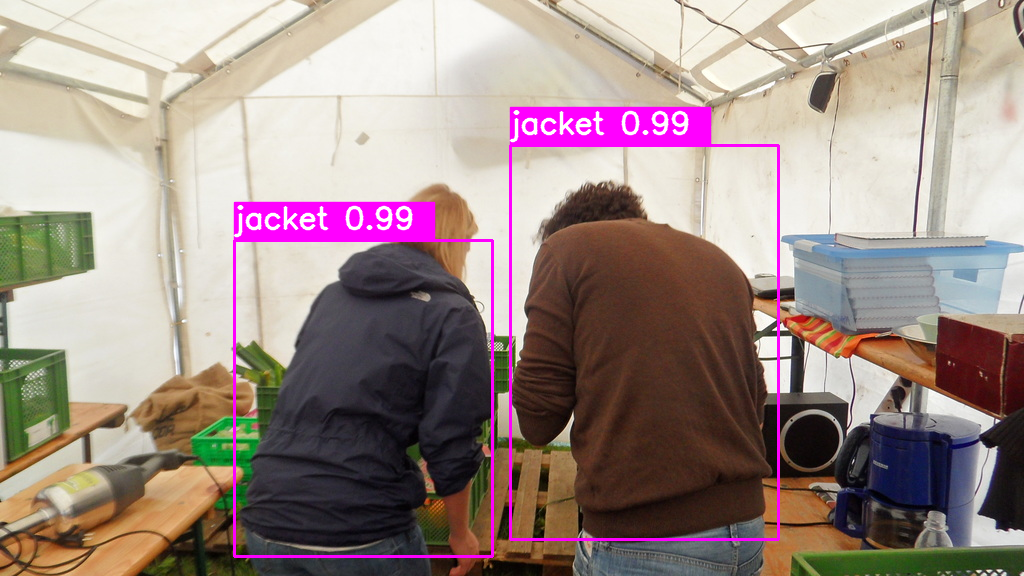

In [10]:
'''
plot bounding box:
    bbox = anchor['bbox']->xmin,ymin,w,h
    label = labelmap[anchor['category_id']]
    color = colormap[anchor['category_id']]
    
    plot_bbox_label(img, label, bbox, color)
    
Note:
    img should be a deepcopy object -> np.array(img)
'''
img1 = np.array(img)
for anchor in train_sample_anchor:
    bbox = anchor['bbox']
    label = labelmap[anchor['category_id']]
    color = colormap[anchor['category_id']]
    img1 = plot_bbox_label(img1, label + ' 0.99', bbox, color)
Image.fromarray(img1[:,:,::-1])

## 1.3) 生成锚框(anchor box):[生成多个锚框](https://zh-v2.d2l.ai/chapter_computer-vision/anchor.html#id2)

In [11]:
def gen_anchor_box(img, fmap_w, fmap_h, size, ratio):
    # input img,fmap_w,fmap_h,size,ratio
    # output bx,by,bw,bh
    img1 = np.array(img)
    h,w = img1.shape[:2]
    anchor_box = []
    for i in range(fmap_w):
        for j in range(fmap_h):
            for s in size:
                for r in ratio:
                    bx = int(w/fmap_w*i + w/fmap_w/2)
                    by = int(h/fmap_h*j + h/fmap_h/2)
                    bw = int(w/fmap_w*s*r**0.5)
                    bh = int(h/fmap_h*s/r**0.5)
                    anchor_box.append([bx,by,bw,bh])
    return anchor_box

In [34]:
%%time
img1 = np.array(img)
fmap_w,fmap_h = 12,22
size = [0.5,1,2,4]
ratio = [1, 2, 0.5]
anchor_box = []
anchor_box = gen_anchor_box(img1, fmap_w, fmap_h, size, ratio)
# anchor_box = gen_anchor_box(img1, 19, 19, size, ratio)
# anchor_box = gen_anchor_box(img1, 9, 9, size, ratio)
# anchor_box = gen_anchor_box(img1, 7, 7, size, ratio)
# anchor_box = gen_anchor_box(img1, 5, 5, size, ratio)
# anchor_box = gen_anchor_box(img1, 3, 3, size, ratio)
# anchor_box = gen_anchor_box(img1, 1, 1, size, ratio)
len(anchor_box)

CPU times: user 58.3 ms, sys: 33.1 ms, total: 91.4 ms
Wall time: 97 ms


3168

In [35]:
anchor_color_map = {i*3+j:[100*(i+j + 1)%255, 150*(i+j+1)%255,200*(i+j+1)%255] for i in range(3) for j in range(3)}
anchor_color_map

{0: [100, 150, 200],
 1: [200, 45, 145],
 2: [45, 195, 90],
 3: [200, 45, 145],
 4: [45, 195, 90],
 5: [145, 90, 35],
 6: [45, 195, 90],
 7: [145, 90, 35],
 8: [245, 240, 235]}

In [36]:
anchor

[981, 562, 482, 296]

In [37]:
len(anchor_box)

3168

CPU times: user 858 ms, sys: 18.4 ms, total: 877 ms
Wall time: 874 ms


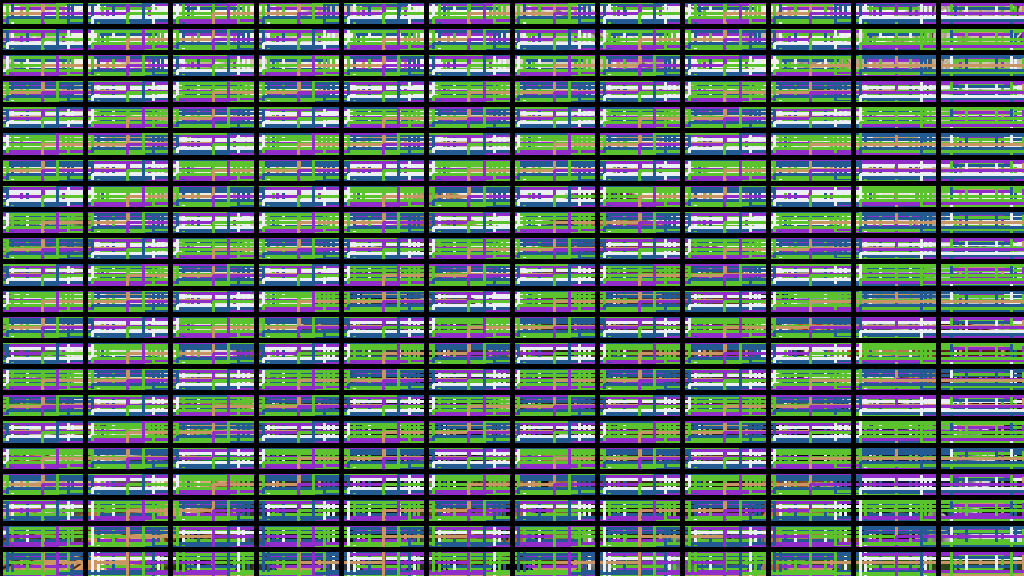

In [38]:
%%time
img1 = np.array(img)
i = 0
for anchor in anchor_box:
    i = i%9
    img1 = plot_anchor_box(img1, '', anchor, color = anchor_color_map[i])
    i += 1
h,w = img1.shape[:2]
for i in range(fmap_w):
        for j in range(fmap_h):
            cv2.line(img1, (int(i*w/fmap_w), int(j*h/fmap_h)),(int((i+1)*w/fmap_w), int(j*h/fmap_h)),[0,0,0],3)
            cv2.line(img1, (int(i*w/fmap_w), int(j*h/fmap_h)),(int((i)*w/fmap_w), int((j+1)*h/fmap_h)),[0,0,0],3)
Image.fromarray(img1[:,:,::-1])

## 1.4) 交并比 (Intersection Over Union):[IOU](https://zh-v2.d2l.ai/chapter_computer-vision/anchor.html#iou)

![image.png](https://zh-v2.d2l.ai/_images/iou.svg)

In [28]:
def box_iou(box1, box2, mode = 0):
    '''
    mode == 0:
        box:xmin,ymin,xmax,ymax
    mode == 1:
        box:xc,yc,w,h
    '''
    if mode:
        box1 = [box1[0] - box1[2]/2, box1[1] - box1[3]/2, box1[0] + box1[2]/2, box1[1] + box1[3]/2]
        box2 = [box2[0] - box2[2]/2, box2[1] - box2[3]/2, box2[0] + box2[2]/2, box2[1] + box2[3]/2]
    
    box_area = lambda box: ((box[2] - box[0]) *
                              (box[3] - box[1]))
    #面积
    area1 = box_area(box1)
    area2 = box_area(box2)
    
    
    inter_upperleft = np.max([box1[:2],box2[:2]],axis = 0)
    inter_lowerright = np.min([box1[2:],box2[2:]],axis = 0)
    inter = inter_lowerright - inter_upperleft

    inter_area = inter[0] * inter[1]
    union_area = area1 + area2 - inter_area
    if inter_area < 0:
        return 0
    
    return inter_area/union_area

![image.png](https://zh-v2.d2l.ai/_images/anchor-label.svg)

In [29]:
an_box = np.random.randn(40*40,4)
b_box = np.random.randn(19*8,4)

In [30]:
def boxes_iou(boxes1, boxes2):
    '''
    input:
        boxes1->anchor box: anchor_num,xmin,ymin,xmax,ymax
        boxes2->bounding box: bbox_num,xmin,ymin,xmax,ymax
    output:
        boxes:anchor_num, bbox_num,xmin,ymin,xmax,ymax
    '''
    an_box_matrix = np.expand_dims(boxes1,1).repeat(boxes2.shape[0],1).reshape(-1,4)
    b_box_matrix = np.expand_dims(boxes2,0).repeat(boxes1.shape[0],0).reshape(-1,4)
    
    box_area = lambda box: ((box[:,2] - box[:,0]) *
                              (box[:,3] - box[:,1]))
    #面积
    areas1 = box_area(an_box_matrix)
    areas2 = box_area(b_box_matrix)
    
    inter_upperlefts = np.max([b_box_matrix[:,:2],an_box_matrix[:,:2]],axis = 0)
    inter_lowerrights = np.min([b_box_matrix[:,2:],an_box_matrix[:,2:]],axis = 0)
    inter = inter_lowerrights - inter_upperlefts
    
    inter_area = inter[:,0] * inter[:,1]
    union_area = areas1 + areas2 - inter_area
    
    ious = inter_area/union_area
    ious = ious.reshape(boxes1.shape[0],boxes2.shape[0])
    
    return ious
    

In [31]:
%%time
ious = boxes_iou(an_box,b_box)

CPU times: user 718 ms, sys: 807 ms, total: 1.52 s
Wall time: 1.57 s


In [32]:
def argmax2(a):
    index = a.argmax()
    return index//a.shape[0],index%a.shape[0]

In [33]:
%%time
argmax2(ious)

CPU times: user 2.11 ms, sys: 0 ns, total: 2.11 ms
Wall time: 2 ms


(125, 802)

# 2. Dataset and Dataloader 